<h2>Machine Learning to Identify Fraud in the Enron Corpus</h2>

In [1]:
# Import the required packages 
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from scipy import stats 

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import warnings 
warnings.filterwarnings("ignore")

<h2>Task 1: Explore the data</h2>
<h3>1.1 Data exploration</h3>
<p>Features of this dataset fall into three major types:<br>- POI label, as the target feature,<br>- Financial features,<br>- Email features</p>

In [2]:
# Create the features list
target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

print(features_list)

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


In [3]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
# Dataset Exploration
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))

Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


In [5]:
# Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))

Each person has 21 features available


<h3>1.2 Replace Missing Values</h3>

In [6]:
# Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0

for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

# Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
from_poi_to_this_person: 60
exercised_stock_options: 44
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
long_term_incentive: 80
shared_receipt_with_poi: 60
restricted_stock: 36
director_fees: 129


Text(0.5, 1.0, 'Number of missing values by feature')

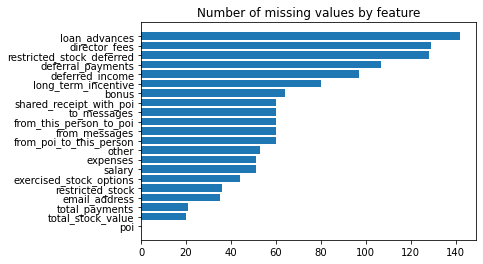

In [7]:
# Visualization of the missing values by feature
missing_values_df = pd.DataFrame.from_dict(missing_values,orient='index')
missing_values_df = missing_values_df.sort_values(by=[0])
plt.barh(missing_values_df.index,missing_values_df[0])
plt.title('Number of missing values by feature')

<p>This visualization reveals that there are lots of missing values in our dataset. There are even 5 features that have more than 100 missing data points out of 146. The features that contain the highest number of missing values are the financial features (loan_advances, director_fees, restricted_stock_deferred, derral_payments, deferred_income, etc.)</p><p>If I remove all the rows that contain missing values, the dataset would become much too small to train an accurate machine learning model. Thus, I will try to impute these missing values.</p>


<h3>1.2.1 Replace Missing Values of the Financial Features</h3>
<p>For the financial features in the financial_features_list, we can assume that the NaN values are zeros. For instance, an employee who do not receive director fees nor a bonus shouldn't have a NaN value but a 0. Thus, I will replace the NaN values in the financial features by zeros.
<br>There is one exception for the salary feature where missing values can’t be zeros. I'll deal with it later on.</p>

In [8]:
# Create a new financial_features_list without salary
financial_features_na = financial_features_list.copy()
financial_features_na.remove("salary")

# Check if the salary variable has been correctly removed 
"salary" in financial_features_na

False

In [9]:
# Replace NaN values of the financial features by zeros in the data_dict
for employee in data_dict.keys():
    for feature in financial_features_na:
        if data_dict[employee][feature] == 'NaN':
            data_dict[employee][feature] = 0

In [10]:
# Check if the NaN values have been correctly replaced
missing_financial_values = {}
for feature in all_features:
    missing_financial_values[feature] = 0

for person in data_dict.keys():
    records = 0
    for feature in financial_features_na:
        if data_dict[person][feature] == 'NaN':
            missing_fiancial_values[feature] += 1
        else:
            records += 1
            
print("Number of Missing Values for Financial Features: (except salary)")
for feature in financial_features_na:
    print("%s: %d" % (feature, missing_financial_values[feature]))

Number of Missing Values for Financial Features: (except salary)
bonus: 0
deferral_payments: 0
deferred_income: 0
director_fees: 0
exercised_stock_options: 0
expenses: 0
loan_advances: 0
long_term_incentive: 0
other: 0
restricted_stock: 0
restricted_stock_deferred: 0
total_payments: 0
total_stock_value: 0


<p> -> The missing values for the financial features (except salary) have correctly been remplaced by zeros.</p>

<h3>1.2.2 Replace missing values of the Salary feature</h3>
<p>There are 51 missing values in the salary feature. 
<br>A missing salary can't be a 0 since each employee should be paid a wage. We can assume that NaN values in the salary variable are true missing values. <br>I choose to replace the missing salaries by the mean of all the salaries: $267,102
</p>

In [11]:
# Convert the data_dict dictionary to a Pandas dataframe 
enron_df = pd.DataFrame.from_dict(data_dict,orient='index')
enron_df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,0,1061827,0,600000,mark.metts@enron.com,0,0,585062,...,38,0,29,1740,1,False,0,702,585062,0
BAXTER JOHN C,267102,NaN,1295738,5634343,0,1200000,NaN,0,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,0
ELLIOTT STEVEN,170941,NaN,0,211725,0,350000,steven.elliott@enron.com,0,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,0,NaN,1788391,0
CORDES WILLIAM R,NaN,764,0,0,0,0,bill.cordes@enron.com,0,0,1038185,...,10,651850,12,0,0,False,0,58,386335,0
HANNON KEVIN P,243293,1045,0,288682,0,1500000,kevin.hannon@enron.com,0,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,0


In [12]:
# Check the data type of the remaining NaN values for the emails features
type(enron_df.loc["BAXTER JOHN C", "to_messages"])

str

<p>-> We can see that the NaN are of type string, which doesn't allow us to use the imputer function to deal with them. Thus, I will replace them with NaN values thanks to the pandas.replace() function</p>

In [13]:
# Convert NaN strings to np.NaN values (null values)
enron_df = enron_df.replace("NaN", np.NaN, regex=True)

In [14]:
# Check again the number of missing values by feature 
enron_df.isna().sum()

salary                       51
to_messages                  60
deferral_payments             0
total_payments                0
loan_advances                 0
bonus                         0
email_address                35
restricted_stock_deferred     0
deferred_income               0
total_stock_value             0
expenses                      0
from_poi_to_this_person      60
exercised_stock_options       0
from_messages                60
other                         0
from_this_person_to_poi      60
poi                           0
long_term_incentive           0
shared_receipt_with_poi      60
restricted_stock              0
director_fees                 0
dtype: int64

In [15]:
# Replace Salary NaN by the mean 
enron_df['salary'].fillna(mean(enron_df['salary']), inplace=True)

In [16]:
# Check if NaN values have correctly been replaced
enron_df['salary'].isna().sum()

0

<h3>1.2.3 Replace Missing Values of the Email features</h3>
<p>The email features are very important because they show the degree of relationship between POI and non-POI employees. Replacing these values by the mean or the median or the most common value of the given columns doesn't appear as an effective solution in this case.</p>
<p>I choose to impute these missing values using Scikit Learn's KNNImputer function. It uses the k-nearest Neighbors algorithm to impute the missing values using the mean value of the nearest neighbors found in the dataset. 
</p>


In [17]:
# New data frame without email_adress (object), POI (bool), and salary variables
enron_df_imputation = enron_df[['to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']]
enron_df_imputation.set_index(enron_df.index.copy())

,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,807.0,0,1061827,0,600000,0,0,585062,94299,38.0,0,29.0,1740,1.0,0,702.0,585062,0
BAXTER JOHN C,NaN,1295738,5634343,0,1200000,0,-1386055,10623258,11200,NaN,6680544,NaN,2660303,NaN,1586055,NaN,3942714,0
ELLIOTT STEVEN,NaN,0,211725,0,350000,0,-400729,6678735,78552,NaN,4890344,NaN,12961,NaN,0,NaN,1788391,0
CORDES WILLIAM R,764.0,0,0,0,0,0,0,1038185,0,10.0,651850,12.0,0,0.0,0,58.0,386335,0
HANNON KEVIN P,1045.0,0,288682,0,1500000,0,-3117011,6391065,34039,32.0,5538001,32.0,11350,21.0,1617011,1035.0,853064,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,NaN,0,119292,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,NaN,0,119292
CAUSEY RICHARD A,1892.0,0,1868758,0,1000000,0,-235000,2502063,30674,58.0,0,49.0,307895,12.0,350000,1585.0,2502063,0
TAYLOR MITCHELL S,533.0,227449,1092663,0,600000,0,0,3745048,0,0.0,3181250,29.0,0,0.0,0,300.0,563798,0
DONAHUE JR JEFFREY M,865.0,0,875760,0,800000,0,-300000,1080988,96268,188.0,765920,22.0,891,11.0,0,772.0,315068,0


In [18]:
# Imputation of remaining NaN values in the dataset with the KNN Imputer function with n=5
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(enron_df_imputation)
enron_df_imputed = pd.DataFrame(imputed, columns=enron_df_imputation.columns)

In [19]:
# Check the imputation result 
enron_df_imputed

,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,807.0,0.0,1061827.0,0.0,600000.0,0.0,0.0,585062.0,94299.0,38.0,0.0,29.0,1740.0,1.0,0.0,702.0,585062.0,0.0
1,2343.4,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,67.8,6680544.0,540.6,2660303.0,12.8,1586055.0,1409.4,3942714.0,0.0
2,843.8,0.0,211725.0,0.0,350000.0,0.0,-400729.0,6678735.0,78552.0,58.4,4890344.0,93.8,12961.0,14.0,0.0,570.2,1788391.0,0.0
3,764.0,0.0,0.0,0.0,0.0,0.0,0.0,1038185.0,0.0,10.0,651850.0,12.0,0.0,0.0,0.0,58.0,386335.0,0.0
4,1045.0,0.0,288682.0,0.0,1500000.0,0.0,-3117011.0,6391065.0,34039.0,32.0,5538001.0,32.0,11350.0,21.0,1617011.0,1035.0,853064.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,575.4,0.0,119292.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,21.8,0.0,1.0,0.0,188.0,0.0,119292.0
142,1892.0,0.0,1868758.0,0.0,1000000.0,0.0,-235000.0,2502063.0,30674.0,58.0,0.0,49.0,307895.0,12.0,350000.0,1585.0,2502063.0,0.0
143,533.0,227449.0,1092663.0,0.0,600000.0,0.0,0.0,3745048.0,0.0,0.0,3181250.0,29.0,0.0,0.0,0.0,300.0,563798.0,0.0
144,865.0,0.0,875760.0,0.0,800000.0,0.0,-300000.0,1080988.0,96268.0,188.0,765920.0,22.0,891.0,11.0,0.0,772.0,315068.0,0.0


In [20]:
# Check the number of NaN values 
enron_df_imputed.isna().sum()

to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
dtype: int64

<p>-> The imputer has correctly imputed the missing values of the email features<br>Missing values are only remaining in the <i>email_address</i> feature. This variable, composed of the email addresses of the employees, is of no interest for us to train the machine learning models. Thus, I will simply drop the entire column (by not re-inserting it).</p>

<p>Now, we must recompose the dataframe and re-convert it to a dictionnary for further manipulation</p>

In [21]:
# Recompose the dataframe
final_df = enron_df_imputed.copy()
final_df = final_df.set_index(enron_df.index.copy())
final_df['poi'] = enron_df['poi'].copy()
final_df['salary'] = enron_df['salary'].copy()

In [22]:
# Check if we have correctly recomposed the dataframe
print(final_df.shape)
print(final_df.columns)

(146, 20)
Index(['to_messages', 'deferral_payments', 'total_payments', 'loan_advances',
       'bonus', 'restricted_stock_deferred', 'deferred_income',
       'total_stock_value', 'expenses', 'from_poi_to_this_person',
       'exercised_stock_options', 'from_messages', 'other',
       'from_this_person_to_poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'poi',
       'salary'],
      dtype='object')


In [23]:
# Convert the dataframe back into a dictionary data_dict
data_dict = final_df.to_dict(orient='index')

<hr>
<h2>Task 2: Remove Outliers</h2>

<p>First of all, I remove the "total row" value since it distorts our data and it is not needed for our machine learning model.</p>

In [24]:
data_dict.pop('TOTAL', 0 )

{'to_messages': 3867.8,
 'deferral_payments': 32083396.0,
 'total_payments': 309886585.0,
 'loan_advances': 83925000.0,
 'bonus': 97343619.0,
 'restricted_stock_deferred': -7576788.0,
 'deferred_income': -27992891.0,
 'total_stock_value': 434509511.0,
 'expenses': 5235198.0,
 'from_poi_to_this_person': 204.6,
 'exercised_stock_options': 311764000.0,
 'from_messages': 553.6,
 'other': 42667589.0,
 'from_this_person_to_poi': 93.4,
 'long_term_incentive': 48521928.0,
 'shared_receipt_with_poi': 2451.6,
 'restricted_stock': 130322299.0,
 'director_fees': 1398517.0,
 'poi': False,
 'salary': 26704229.0}

In [25]:
# Check the number of data points in the dictionary before removing outliers 
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))

Total number of data points: 145


<h3>2.1 Visualize Outliers</h3>

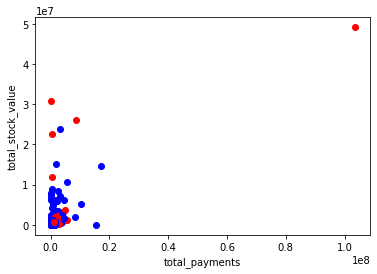

None


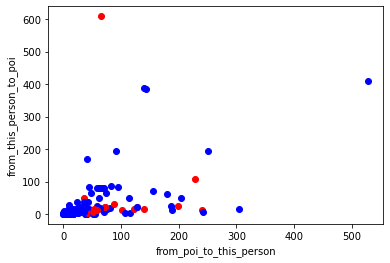

None


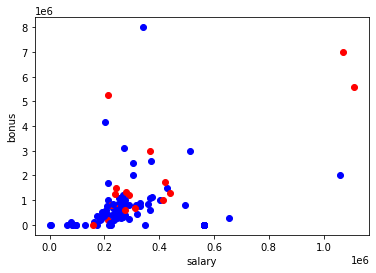

None


In [26]:
# Visualise outliers
def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()
    
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))

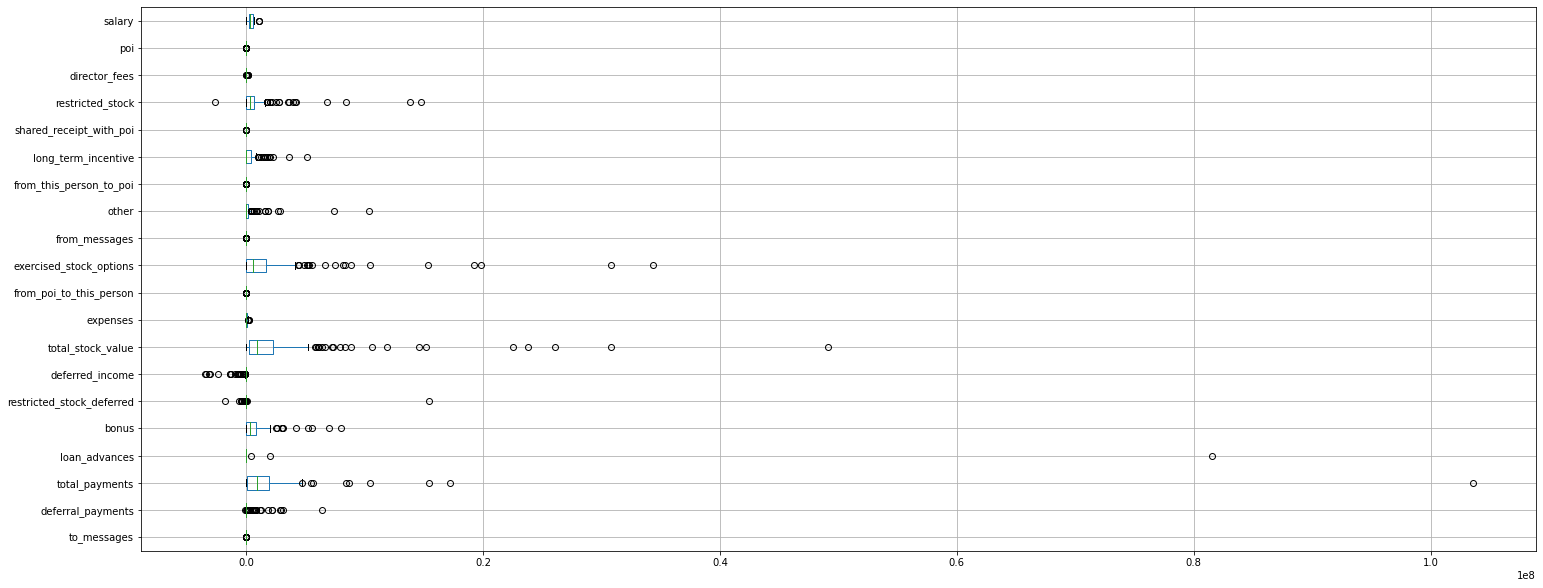

In [45]:
# Convert the dictionary into a dataframe to produce more visualization 
dataset_outliers = pd.DataFrame.from_dict(data_dict,orient='index')

# Boxplot of all the variables of the dataset 
boxplot = dataset_outliers.boxplot(figsize=(25,10),vert=False)

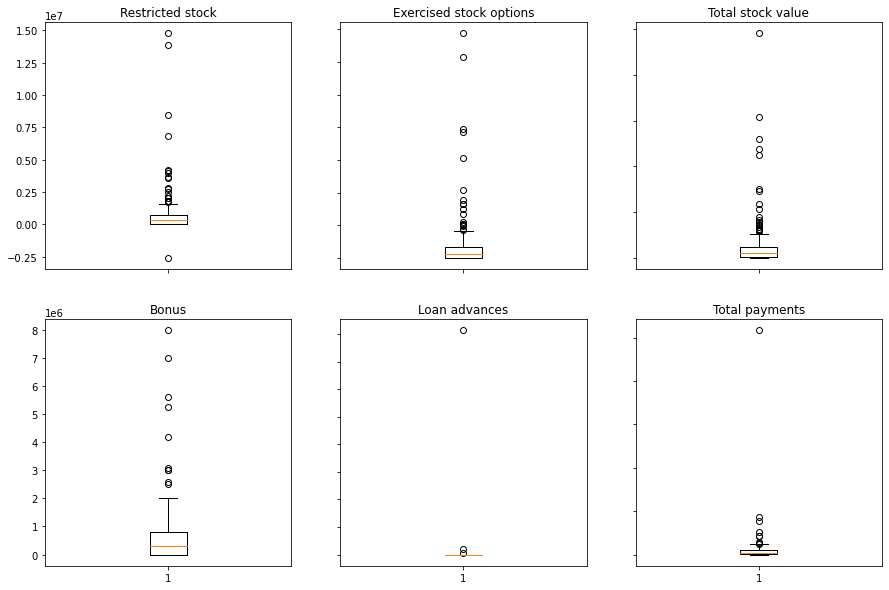

In [46]:
# Produce six boxplots 
fig, axs = plt.subplots(2, 3,figsize=(15,10))
axs[0, 0].boxplot(dataset_outliers['restricted_stock'])
axs[0, 0].set_title('Restricted stock')

axs[0, 1].boxplot(dataset_outliers['exercised_stock_options'])
axs[0, 1].set_title('Exercised stock options')

axs[0, 2].boxplot(dataset_outliers['total_stock_value'])
axs[0, 2].set_title('Total stock value')

axs[1, 0].boxplot(dataset_outliers['bonus'])
axs[1, 0].set_title('Bonus')

axs[1, 1].boxplot(dataset_outliers['loan_advances'])
axs[1, 1].set_title('Loan advances')

axs[1, 2].boxplot(dataset_outliers['total_payments'])
axs[1, 2].set_title('Total payments')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

<h3>2.2 Identify Outliers using Z-score</h3>
<p>I decide to use the Z-score to identify the outliers. The Z-score is the number of standard deviations away from the mean that a certain data point is.</p><p>Since the dataset is very small and since there are big outliers, I decide to classify outlier all the people that have a value (in any feature) superior to a Z-score of 6. That is, six standard deviations away from the mean of the feature.</p>

In [47]:
from scipy.stats import zscore

dataset_outliers.pop('poi')
z_scores = dataset_outliers.apply(zscore)
# depending on your python/scipy version
# z_scores = stats.zscore(dataset_outliers)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 6).all(axis=1)

In [49]:
outliers = filtered_entries[filtered_entries==False].index.values.tolist()

In [50]:
outliers

['LAVORATO JOHN J',
 'SHAPIRO RICHARD S',
 'DELAINEY DAVID W',
 'LAY KENNETH L',
 'KAMINSKI WINCENTY J',
 'WHITE JR THOMAS E',
 'BHATNAGAR SANJAY',
 'HIRKO JOSEPH',
 'FREVERT MARK A',
 'MARTIN AMANDA K']

<p>This operation allows me to identify 10 people. I keep the people who are labeled as Person of Interest (POI) since this is the target variable and this information will be very precious to build our machine learning model.</p>

In [51]:
outliers_not_poi = []

for person in data_dict.keys(): 
    if person in outliers and data_dict[person]['poi'] == False: 
        outliers_not_poi.append(person)

In [53]:
outliers_not_poi

['LAVORATO JOHN J',
 'SHAPIRO RICHARD S',
 'KAMINSKI WINCENTY J',
 'WHITE JR THOMAS E',
 'BHATNAGAR SANJAY',
 'FREVERT MARK A',
 'MARTIN AMANDA K']

<p>There are 9 outliers (not POI) that can be removed from the dataset.</p>

<h3>2.3 Remove outliers</h3>

In [54]:
# Function to remove outliers
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)
        
outliers_default = ['THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
outliers_not_poi = outliers_not_poi + outliers_default

remove_outlier(data_dict, outliers)

In [55]:
# Checking the number of data points after the outliers have been removed 
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))

Total number of data points: 135


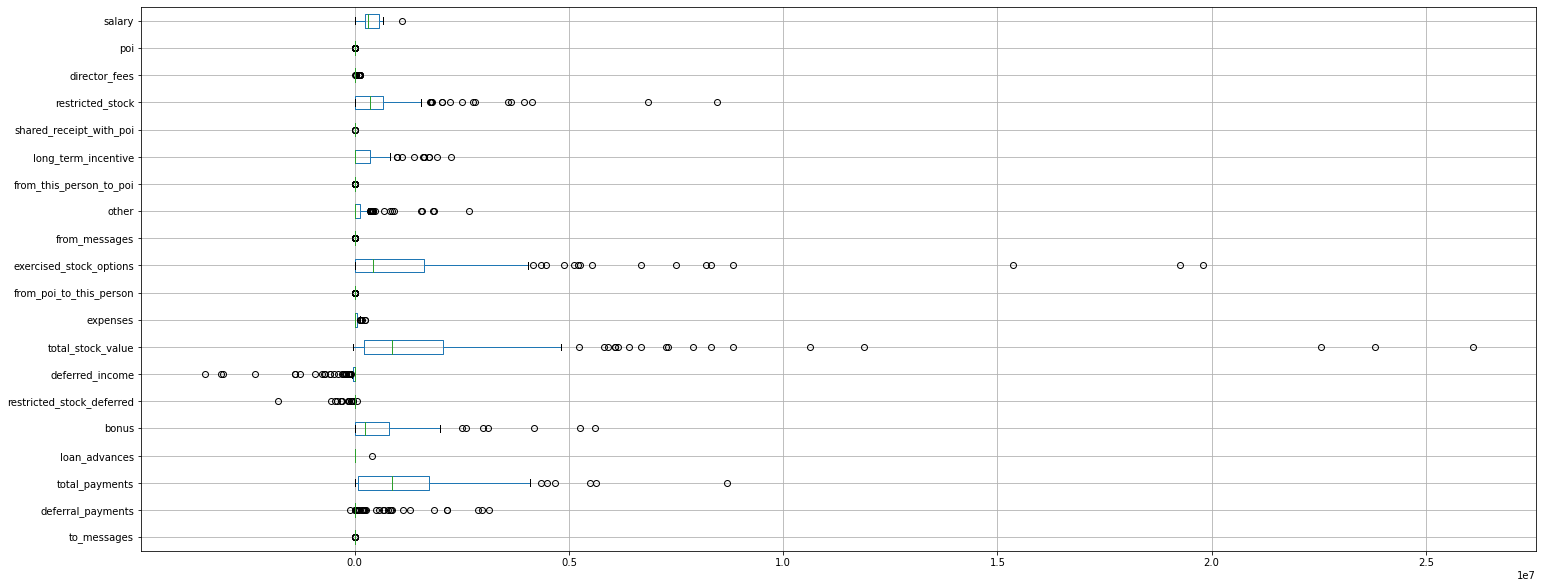

In [56]:
# Convert the dictionary into a dataframe to visualize the result without the outliers  
dataset_no_outliers = pd.DataFrame.from_dict(data_dict,orient='index')

# Boxplot of all the variables of the dataset 
boxplot = dataset_no_outliers.boxplot(figsize=(25,10),vert=False)

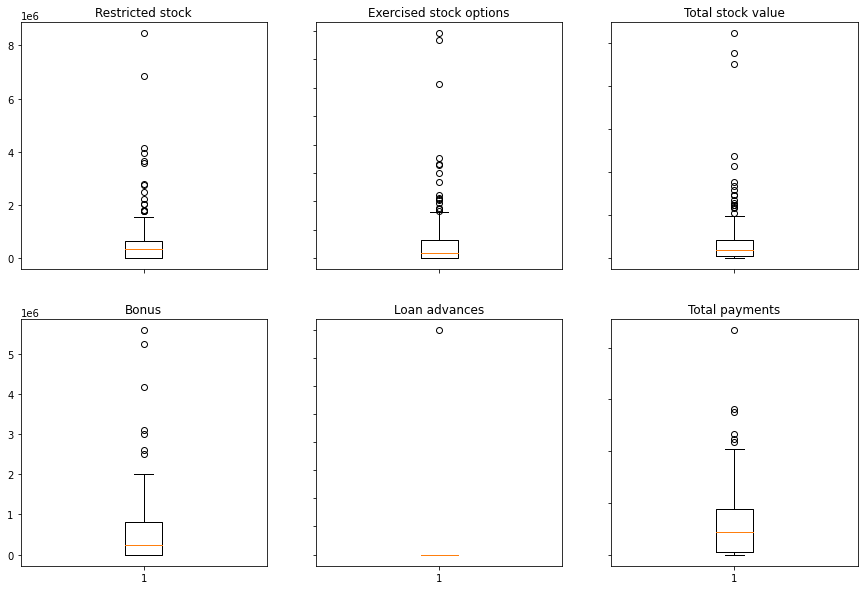

In [57]:
# Produce six boxplots 
fig, axs = plt.subplots(2, 3,figsize=(15,10))
axs[0, 0].boxplot(dataset_no_outliers['restricted_stock'])
axs[0, 0].set_title('Restricted stock')

axs[0, 1].boxplot(dataset_no_outliers['exercised_stock_options'])
axs[0, 1].set_title('Exercised stock options')

axs[0, 2].boxplot(dataset_no_outliers['total_stock_value'])
axs[0, 2].set_title('Total stock value')

axs[1, 0].boxplot(dataset_no_outliers['bonus'])
axs[1, 0].set_title('Bonus')

axs[1, 1].boxplot(dataset_no_outliers['loan_advances'])
axs[1, 1].set_title('Loan advances')

axs[1, 2].boxplot(dataset_no_outliers['total_payments'])
axs[1, 2].set_title('Total payments')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

<p>As we can see, the biggest outliers have been removed but there are still some of them. However, since the dataset is very small, we can’t afford to remove more as too much information for the model will be lost (the dataset is now be composed of 135 employees).</p>

<hr>
<h2>Task 3. Create new features</h2>
<h3>3.1 Create new calculated features</h3>
<p>Now, I will create new features for improving the accuracy of the machine learning model we will build.</p>

In [58]:
my_dataset = data_dict

# Function to compute fraction 
def compute_fraction(x, y):
    if x == 0 or y == 0:
        return 0.
    fraction = x / y
    return fraction

# Creating new variables by using the function compute_fraction
for name in my_dataset:
    data_point = my_dataset[name]
    
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    
    to_messages = data_point["to_messages"]
    
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
    
    shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
    
    fraction_shared_poi = compute_fraction(shared_receipt_with_poi,to_messages)
    
    data_point["fraction_shared_poi"] = fraction_shared_poi
    bonus = data_point["bonus"]
    salary = data_point["salary"]
    
    bonus_to_salary = compute_fraction(bonus, salary)
    
    data_point["bonus_to_salary"] = bonus_to_salary
    total_payments = data_point["total_payments"]
    
    bonus_to_total = compute_fraction(bonus, total_payments)
    data_point["bonus_to_total"] = bonus_to_total
    
    exercised_stock_options= data_point["exercised_stock_options"]
    total_stock_value= data_point["total_stock_value"]
    
    exercised_stock_options_fraction = compute_fraction(exercised_stock_options, total_stock_value)
    data_point["exercised_stock_options_fraction"] = exercised_stock_options_fraction
    
    perc_salary = compute_fraction(salary, total_payments)
    data_point["perc_salary"] = perc_salary   
    
    total_messages = to_messages + from_messages
    data_point["total_messages"] = total_messages
    
    total_messages_with_poi = from_this_person_to_poi + from_poi_to_this_person + shared_receipt_with_poi
    data_point["total_messages_with_poi"] = total_messages_with_poi
    
    message_shared_fraction = compute_fraction(total_messages_with_poi, total_messages)
    data_point["message_shared_fraction"] = message_shared_fraction

<p>I've decided to create 10 new features: fraction_from_poi, fraction_to_poi, fraction_shared_poi, bonus_to_salary, bonus_to_total, exercised_stock_options_fraction, perc_salary, total_messages, total_messages_with_poi, message_shared_fraction</p> 

In [59]:
# Create new copies of feature list for grading
my_feature_list = features_list + ['fraction_from_poi','fraction_to_poi', 'fraction_shared_poi','bonus_to_salary','bonus_to_total','exercised_stock_options_fraction', 'perc_salary', 'total_messages', 'total_messages_with_poi', 'message_shared_fraction']
len(my_feature_list)

30

<h3>3.2 Select best features</h3>
<p>I have to choose the best features for the model. The best features are the ones that explain the most the target variable (POI).<br>I decide to use Scikit learn’s SelectKbest to select the best features and decide to retain the first 5 features with the highest scores (among the 30 variables).</p>

In [60]:
# Get K-best features
num_features = 5

# Function using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)
    
    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features


best_features = get_k_best(my_dataset, my_feature_list, num_features)
my_feature_list = [target_label] + list(set(best_features.keys()))

[2.23280674e+01 4.15379414e-02 1.90824904e+01 1.71292577e+00
 9.94036109e+00 4.13934885e+00 1.24183007e-01 1.32991321e+01
 1.50450665e+00 9.64545703e+00 7.18516304e-01 5.58901658e-01
 1.05846211e+01 1.16294440e+01 1.25309830e+00 1.10426326e+01
 8.63733427e-04 1.43282890e+01 2.47488303e+00 3.17193570e+00
 1.61952299e+01 1.64122758e+01 1.32730977e+01 2.60255864e+01
 3.63525622e-01 2.80656373e-01 4.71652713e-01 1.36687384e+01
 1.85167969e+01]
5 best features: dict_keys(['bonus_to_total', 'bonus', 'deferred_income', 'message_shared_fraction', 'fraction_shared_poi'])



In [61]:
# Print features
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

5 selected features: ['bonus_to_total', 'bonus', 'fraction_shared_poi', 'message_shared_fraction', 'deferred_income']



In [62]:
# Extract the features specified in my_features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)

# Split into labels and features
labels, features = targetFeatureSplit(data)

# Scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

<hr>
<h2>Task 4: Try a variety of classifiers</h2>
<p>To select the best model, we use the evaluate_clf function. It splits the dataset into training and test sets, fits each classifier to the training set and at the end evaluates the model on the test set with the precision and recall metrics.</p>

In [63]:
# Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

# K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

# Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)

# Gradient Boosting Classifier
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

In [65]:
# Evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)


# Evaluate all functions
print("\n=> Evaluation of Gaussian Naive Bayes Classifier")
evaluate_clf(g_clf, features, labels)
print("\n=> Evaluation of Logistic Regression Classifier")
evaluate_clf(l_clf, features, labels)
print("\n=> Evaluation of K-means Clustering")
evaluate_clf(k_clf, features, labels)
print("\n=> Evaluation of Support Vector Machine Classifier")
evaluate_clf(s_clf, features, labels)
print("\n=> Evaluation of Random Forest")
evaluate_clf(rf_clf, features, labels)
print("\n=> Evaluation of Gradient Boosting Classifier")
evaluate_clf(gb_clf, features, labels)


=> Evaluation of Gaussian Naive Bayes Classifier
GaussianNB()

Processing....................................................................................................done.

precision: 0.39549697802197803
recall:    0.30556547619047614

=> Evaluation of Logistic Regression Classifier
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.45687226662226665
recall:    0.4431132756132756

=> Evaluation of K-means Clustering
KMeans(n_clusters=2, tol=0.001)

Processing....................................................................................................done.

precision: 0.11030487373549662
recall:    0.5033698412698412

=> Evaluation of Support Vector Machine Classifier
S

(0.38305917138417134, 0.3040984126984127)

<p>-> The results show us that the Logistic Regression has the best precision and recall metrucs. Thus, I will choose this model.</p>

In [66]:
# Select Logistic Regression as final algorithm
clf = l_clf

In [67]:
# Dump the classifier, dataset and features_list so anyone can run/check the results
pickle.dump(clf, open("my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("my_feature_list.pkl", "wb"))

<hr>
<h2>Task 5: Tune the classifier to achieve better than .42 precision and recall</h2>
<p>Achieve better than .42 precision and recall by using the testing script.</p>

<h3>5.1 Split the dataset into training and test sets</h3>
<p>I split the dataset into a training set (70% of the data) and a test set (30% of the data).</p>

In [68]:
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

<h3>5.2 Find the best parameters with GridSearch</h3>
<p>To find the best parameters for logistic regression, I perform a multi-metric evaluation on cross_val_score and GridSearchCV. 
The Stratified K-Folds cross-validator is used for the cross-validation strategy with 10 folds.<br>The chosen scorers are the following ones: precision_score, recall_score, accuracy_score and f1_score.<br>Ultimately, I choose the f1_score to refit the estimator with the parameters setting that has the best cross-validated f1_score. 
</p>

In [69]:
# Create a the logistic regression parameters grid
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear', 'lbfgs', 'newton-cg'],
    }
]

# Add the scorers in a dict
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Function to run StratifiedKFold and GridSearchCV and produce a confusion matrix
def grid_search_parameters(x, y): 
    cv = StratifiedKFold(n_splits=10)
    clf = GridSearchCV(LogisticRegression(), param_grid, scoring=scorers, refit='f1_score', cv=cv, return_train_score=True, n_jobs=-1)
    clf.fit(x,y)
        
    # make the predictions
    y_pred = clf.predict(features_test)
    print('Best parameters using f1-score')
    print(clf.best_params_)
        
    # confusion matrix on the test data.
    print('Confusion matrix of Logistic Regression optimized for f1-score on the test set')
    print(pd.DataFrame(confusion_matrix(labels_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    return clf.best_params_

In [70]:
# Run GridSearchCV 
grid_search_clf = grid_search_parameters(features_train, labels_train)

Best parameters using f1-score
{'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion matrix of Logistic Regression optimized for f1-score on the test set
     pred_neg  pred_pos
neg        33         1
pos         5         2


In [71]:
# Print the best scores for the logistic regression 
grid_search_clf

{'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}

<h3>5.3 Fit the model</h3>
<p>I can now fit our logistic regression with the best parameters found by GridSearchCV.</p>

In [72]:
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=grid_search_clf['C'], class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
                                          max_iter=100, multi_class='ovr', penalty=grid_search_clf['penalty'], 
                                          random_state=42, solver=grid_search_clf['solver'], tol=0.001, verbose=0))])

In [73]:
l_clf.fit(features_train, labels_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1.623776739188721,
                                    class_weight='balanced', multi_class='ovr',
                                    penalty='l1', random_state=42,
                                    solver='liblinear', tol=0.001))])

In [74]:
# Accuracy score 
l_clf.score(features_test, labels_test)

0.7560975609756098

In [75]:
clf = l_clf

<hr>
<h2>Task 6: Dump and Evaluate the classifier</h2>
<p>Dump the classifier, dataset, and features_list so anyone can check my results.</p>

In [76]:
from tester import dump_classifier_and_data

dump_classifier_and_data(clf, my_dataset, features_list)

In [77]:
#TESTER.PY

#!/usr/bin/pickle python -W ignore::DeprecationWarning

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively
    that process should happen at the end of poi_id.py
"""

import pickle
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

from sklearn.model_selection import StratifiedShuffleSplit


PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(n_splits=folds, random_state=42)
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv.split(features, labels):
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print ("Warning: Found a predicted label not == 0 or 1.")
                print ("All predictions should take value 0 or 1.")
                print ("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print (clf)
        print (PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print (RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print ("")
    except:
        print ("Got a divide by zero when trying out:", clf)
        print ("Precision or recall may be undefined due to a lack of true positive predicitons.")

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "rb") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "rb") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "rb") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1.623776739188721,
                                    class_weight='balanced', multi_class='ovr',
                                    penalty='l1', random_state=42,
                                    solver='liblinear', tol=0.001))])
	Accuracy: 0.82414	Precision: 0.42558	Recall: 0.66050	F1: 0.51763	F2: 0.59483
	Total predictions: 14000	True positives: 1321	False positives: 1783	False negatives:  679	True negatives: 10217

